In [1]:
import pandas as pd
import numpy as np

import re

In [3]:
# Load in the train and test datasets
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [13]:


print(train['Pclass'].value_counts() )

title_names = (train['Pclass'].value_counts() < 200)
print(title_names)

train['Title'] = train['Pclass'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

train.sample(10)

3    491
1    216
2    184
Name: Pclass, dtype: int64
3    False
1    False
2     True
Name: Pclass, dtype: bool


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
628,629,0,3,"Bostandyeff, Mr. Guentcho",male,26.0,0,0,349224,7.8958,NaN,S,3
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S,Misc
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C,1
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.0,0,0,250646,13.0000,NaN,S,Misc
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,3
385,386,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5000,NaN,S,Misc
531,532,0,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C,3
524,525,0,3,"Kassem, Mr. Fared",male,NaN,0,0,2700,7.2292,NaN,C,3
411,412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q,3
491,492,0,3,"Windelov, Mr. Einar",male,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,S,3


In [25]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

data1_dummy = pd.get_dummies(train[['Sex','Age']])
    
data1_dummy.head()

,Age,Sex_female,Sex_male
0,22.0,0,1
1,38.0,1,0
2,26.0,1,0
3,35.0,1,0
4,35.0,0,1


In [10]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
 # Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

train.head(10)

D:\Anaconda2\envs\python36\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,0,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3


In [11]:
print(train.astype(float).corr())

             Survived    Pclass       Sex       Age     Parch      Fare  \
Survived     1.000000 -0.338481 -0.543351 -0.051332  0.081629  0.295875   
Pclass      -0.338481  1.000000  0.131900 -0.321259  0.018443 -0.628459   
Sex         -0.543351  0.131900  1.000000  0.077543 -0.245489 -0.248940   
Age         -0.051332 -0.321259  0.077543  1.000000 -0.147606  0.078819   
Parch        0.081629  0.018443 -0.245489 -0.147606  1.000000  0.393048   
Fare         0.295875 -0.628459 -0.248940  0.078819  0.393048  1.000000   
Embarked     0.106811  0.045702 -0.116569  0.005131 -0.078665 -0.091096   
Name_length  0.332350 -0.220001 -0.448759  0.044095  0.252282  0.334176   
Has_Cabin    0.316912 -0.725541 -0.140391  0.236747  0.036987  0.497108   
FamilySize   0.016639  0.065997 -0.200988 -0.203705  0.783111  0.465815   
IsAlone     -0.203367  0.135207  0.303646  0.133694 -0.583398 -0.568942   
Title        0.407753 -0.173929 -0.502713 -0.067387  0.315784  0.341665   

             Embarked  N

In [25]:
title_search = re.search(' ([A-Za-z]+)\.', 'Nasser, Mrs. Nicholas (Adele Achem)')
if title_search:
    print(title_search.group(1))
print(title_search)

Mrs
<_sre.SRE_Match object; span=(7, 12), match=' Mrs.'>


In [22]:
from sklearn.cross_validation import KFold

ntrain = 30
ntest = 20
NFOLDS =5
SEED = 0 # for reproducibility

kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED,shuffle=True)
print(kf)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    print(oof_test_skf)

    for i, (train_index, test_index) in enumerate(kf):
        print(i, (train_index, test_index))
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

get_oof(None,np.ones(ntrain),np.ones(ntrain),np.ones(ntest))

sklearn.cross_validation.KFold(n=30, n_folds=5, shuffle=True, random_state=0)
[[4.94e-324 9.88e-324 1.48e-323 1.98e-323 2.47e-323 2.96e-323 3.46e-323
  3.95e-323 4.45e-323 4.94e-323 0.00e+000 4.94e-324 4.94e-324 4.94e-324
  0.00e+000 0.00e+000 0.00e+000 0.00e+000 4.94e-324 4.94e-324]
 [1.48e-323 4.94e-324 1.48e-323 4.94e-324 1.48e-323 1.48e-323 4.94e-324
  1.48e-323 1.48e-323 9.88e-324 4.94e-324 4.94e-324 0.00e+000 4.94e-324
  0.00e+000 0.00e+000 0.00e+000 1.48e-323 0.00e+000 4.94e-324]
 [0.00e+000 0.00e+000 0.00e+000 0.00e+000 0.00e+000 0.00e+000 0.00e+000
  4.94e-324 9.88e-324 0.00e+000 1.14e-322 2.52e-322 1.09e-322 2.17e-322
  1.19e-322 7.91e-323 1.14e-322 1.48e-322 2.42e-322 1.73e-322]
 [0.00e+000 4.94e-324 0.00e+000 4.94e-324 0.00e+000 0.00e+000 4.94e-324
  0.00e+000 0.00e+000 0.00e+000 9.88e-324 9.88e-324 4.94e-324 9.88e-324
  4.94e-324 4.94e-324 4.94e-324 2.47e-323 1.48e-323 9.88e-324]
 [0.00e+000 0.00e+000 4.94e-324 0.00e+000 4.94e-324 4.94e-324 4.94e-324
  0.00e+000 0.00e+000 

In [26]:
import numpy as np

a = np.random.random((1280,720))

import matplotlib.pyplot as plt
%matplotlib inline

b=np.zeros((1280,720))
b[300:900,150:450]=1



In [27]:
%timeit c = a*b

4.66 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


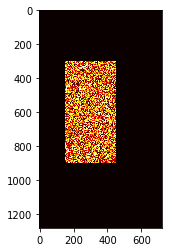

In [29]:
c = a*b
plt.imshow(c,cmap='hot')